A5_Build_TicTacToe_Agent

This notebook contains the code for the tic tac toe problem.

In [ ]:
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
# Simple reinforcement learning algorithm for learning tic-tac-toe
# Use the update rule: V(s) = V(s) + alpha*(V(s') - V(s))
# Use the epsilon-greedy policy:
#   action|s = argmax[over all actions possible from state s]{ V(s) }  if rand > epsilon
#   action|s = select random action from possible actions from state s if rand < epsilon
#
# INTERESTING THINGS TO TRY:
#
# Currently, both agents use the same learning strategy while they play against each other.
# What if they have different learning rates?
# What if they have different epsilons? (probability of exploring)
#   Who will converge faster?
# What if one agent doesn't learn at all?
#   Poses an interesting philosophical question: If there's no one around to challenge you,
#   can you reach your maximum potential?
from __future__ import print_function, division
from builtins import range, input

import numpy as np
import matplotlib.pyplot as plt

LENGTH = 3


class Agent:
  def __init__(self, eps=0.1, alpha=0.5):
    self.eps = eps # probability of choosing random action instead of greedy
    self.alpha = alpha # learning rate
    self.verbose = False
    self.state_history = []
  
  def setV(self, V):
    self.V = V

  def set_symbol(self, sym):
    self.sym = sym

  def set_verbose(self, v):
    # if true, will print values for each position on the board
    self.verbose = v

  def reset_history(self):
    self.state_history = []

  def take_action(self, env):
    # choose an action based on epsilon-greedy strategy
    r = np.random.rand()
    best_state = None
    if r < self.eps:
      # take a random action
      if self.verbose:
        print("Taking a random action")

      possible_moves = []
      for i in range(LENGTH):
        for j in range(LENGTH):
          if env.is_empty(i, j):
            possible_moves.append((i, j))
      idx = np.random.choice(len(possible_moves))
      next_move = possible_moves[idx]
    else:
      # choose the best action based on current values of states
      # loop through all possible moves, get their values
      # keep track of the best value
      pos2value = {} # for debugging
      next_move = None
      best_value = -1
      for i in range(LENGTH):
        for j in range(LENGTH):
          if env.is_empty(i, j):
            # what is the state if we made this move?
            env.board[i,j] = self.sym
            state = env.get_state()
            env.board[i,j] = 0 # don't forget to change it back!
            pos2value[(i,j)] = self.V[state]
            if self.V[state] > best_value:
              best_value = self.V[state]
              best_state = state
              next_move = (i, j)

      # if verbose, draw the board w/ the values
      if self.verbose:
        print("Taking a greedy action")
        for i in range(LENGTH):
          print("------------------")
          for j in range(LENGTH):
            if env.is_empty(i, j):
              # print the value
              print(" %.2f|" % pos2value[(i,j)], end="")
            else:
              print("  ", end="")
              if env.board[i,j] == env.x:
                print("x  |", end="")
              elif env.board[i,j] == env.o:
                print("o  |", end="")
              else:
                print("   |", end="")
          print("")
        print("------------------")

    # make the move
    env.board[next_move[0], next_move[1]] = self.sym

  def update_state_history(self, s):
    # cannot put this in take_action, because take_action only happens
    # once every other iteration for each player
    # state history needs to be updated every iteration
    # s = env.get_state() # don't want to do this twice so pass it in
    self.state_history.append(s)

  def update(self, env):
    # we want to BACKTRACK over the states, so that:
    # V(prev_state) = V(prev_state) + alpha*(V(next_state) - V(prev_state))
    # where V(next_state) = reward if it's the most current state
    #
    # NOTE: we ONLY do this at the end of an episode
    # not so for all the algorithms we will study
    reward = env.reward(self.sym)
    target = reward
    for prev in reversed(self.state_history):
      value = self.V[prev] + self.alpha*(target - self.V[prev])
      self.V[prev] = value
      target = value
    self.reset_history()


# this class represents a tic-tac-toe game
# is a CS101-type of project
class Environment:
  def __init__(self):
    self.board = np.zeros((LENGTH, LENGTH))
    self.x = -1 # represents an x on the board, player 1
    self.o = 1 # represents an o on the board, player 2
    self.winner = None
    self.ended = False
    self.num_states = 3**(LENGTH*LENGTH)

  def is_empty(self, i, j):
    return self.board[i,j] == 0

  def reward(self, sym):
    # no reward until game is over
    if not self.game_over():
      return 0

    # if we get here, game is over
    # sym will be self.x or self.o
    return 1 if self.winner == sym else 0

  def get_state(self):
    # returns the current state, represented as an int
    # from 0...|S|-1, where S = set of all possible states
    # |S| = 3^(BOARD SIZE), since each cell can have 3 possible values - empty, x, o
    # some states are not possible, e.g. all cells are x, but we ignore that detail
    # this is like finding the integer represented by a base-3 number
    k = 0
    h = 0
    for i in range(LENGTH):
      for j in range(LENGTH):
        if self.board[i,j] == 0:
          v = 0
        elif self.board[i,j] == self.x:
          v = 1
        elif self.board[i,j] == self.o:
          v = 2
        h += (3**k) * v
        k += 1
    return h

  def game_over(self, force_recalculate=False):
    # returns true if game over (a player has won or it's a draw)
    # otherwise returns false
    # also sets 'winner' instance variable and 'ended' instance variable
    if not force_recalculate and self.ended:
      return self.ended
    
    # check rows
    for i in range(LENGTH):
      for player in (self.x, self.o):
        if self.board[i].sum() == player*LENGTH:
          self.winner = player
          self.ended = True
          return True

    # check columns
    for j in range(LENGTH):
      for player in (self.x, self.o):
        if self.board[:,j].sum() == player*LENGTH:
          self.winner = player
          self.ended = True
          return True

    # check diagonals
    for player in (self.x, self.o):
      # top-left -> bottom-right diagonal
      if self.board.trace() == player*LENGTH:
        self.winner = player
        self.ended = True
        return True
      # top-right -> bottom-left diagonal
      if np.fliplr(self.board).trace() == player*LENGTH:
        self.winner = player
        self.ended = True
        return True

    # check if draw
    if np.all((self.board == 0) == False):
      # winner stays None
      self.winner = None
      self.ended = True
      return True

    # game is not over
    self.winner = None
    return False

  def is_draw(self):
    return self.ended and self.winner is None

  # Example board
  # -------------
  # | x |   |   |
  # -------------
  # |   |   |   |
  # -------------
  # |   |   | o |
  # -------------
  def draw_board(self):
    for i in range(LENGTH):
      print("-------------")
      for j in range(LENGTH):
        print("  ", end="")
        if self.board[i,j] == self.x:
          print("x ", end="")
        elif self.board[i,j] == self.o:
          print("o ", end="")
        else:
          print("  ", end="")
      print("")
    print("-------------")



class Human:
  def __init__(self):
    pass

  def set_symbol(self, sym):
    self.sym = sym

  def take_action(self, env):
    while True:
      # break if we make a legal move
      move = input("Enter coordinates i,j for your next move (i,j=0..2): ")
      i, j = move.split(',')
      i = int(i)
      j = int(j)
      if env.is_empty(i, j):
        env.board[i,j] = self.sym
        break

  def update(self, env):
    pass

  def update_state_history(self, s):
    pass


# recursive function that will return all
# possible states (as ints) and who the corresponding winner is for those states (if any)
# (i, j) refers to the next cell on the board to permute (we need to try -1, 0, 1)
# impossible games are ignored, i.e. 3x's and 3o's in a row simultaneously
# since that will never happen in a real game
def get_state_hash_and_winner(env, i=0, j=0):
  results = []

  for v in (0, env.x, env.o):
    env.board[i,j] = v # if empty board it should already be 0
    if j == 2:
      # j goes back to 0, increase i, unless i = 2, then we are done
      if i == 2:
        # the board is full, collect results and return
        state = env.get_state()
        ended = env.game_over(force_recalculate=True)
        winner = env.winner
        results.append((state, winner, ended))
      else:
        results += get_state_hash_and_winner(env, i + 1, 0)
    else:
      # increment j, i stays the same
      results += get_state_hash_and_winner(env, i, j + 1)

  return results

# play all possible games
# need to also store if game is over or not
# because we are going to initialize those values to 0.5
# NOTE: THIS IS SLOW because MANY possible games lead to the same outcome / state
# def get_state_hash_and_winner(env, turn='x'):
#   results = []

#   state = env.get_state()
#   # board_before = env.board.copy()
#   ended = env.game_over(force_recalculate=True)
#   winner = env.winner
#   results.append((state, winner, ended))

#   # DEBUG
#   # if ended:
#   #   if winner is not None and env.win_type.startswith('col'):
#   #     env.draw_board()
#   #     print "Winner:", 'x' if winner == -1 else 'o', env.win_type
#   #     print "\n\n"
#   #     assert(np.all(board_before == env.board))

#   if not ended:
#     if turn == 'x':
#       sym = env.x
#       next_sym = 'o'
#     else:
#       sym = env.o
#       next_sym = 'x'

#     for i in xrange(LENGTH):
#       for j in xrange(LENGTH):
#         if env.is_empty(i, j):
#           env.board[i,j] = sym
#           results += get_state_hash_and_winner(env, next_sym)
#           env.board[i,j] = 0 # reset it
#   return results


def initialV_x(env, state_winner_triples):
  # initialize state values as follows
  # if x wins, V(s) = 1
  # if x loses or draw, V(s) = 0
  # otherwise, V(s) = 0.5
  V = np.zeros(env.num_states)
  for state, winner, ended in state_winner_triples:
    if ended:
      if winner == env.x:
        v = 1
      else:
        v = 0
    else:
      v = 0.5
    V[state] = v
  return V


def initialV_o(env, state_winner_triples):
  # this is (almost) the opposite of initial V for player x
  # since everywhere where x wins (1), o loses (0)
  # but a draw is still 0 for o
  V = np.zeros(env.num_states)
  for state, winner, ended in state_winner_triples:
    if ended:
      if winner == env.o:
        v = 1
      else:
        v = 0
    else:
      v = 0.5
    V[state] = v
  return V


def play_game(p1, p2, env, draw=False):
  # loops until the game is over
  current_player = None
  while not env.game_over():
    # alternate between players
    # p1 always starts first
    if current_player == p1:
      current_player = p2
    else:
      current_player = p1

    # draw the board before the user who wants to see it makes a move
    if draw:
      if draw == 1 and current_player == p1:
        env.draw_board()
      if draw == 2 and current_player == p2:
        env.draw_board()

    # current player makes a move
    current_player.take_action(env)

    # update state histories
    state = env.get_state()
    p1.update_state_history(state)
    p2.update_state_history(state)

  if draw:
    env.draw_board()

  # do the value function update
  p1.update(env)
  p2.update(env)


if __name__ == '__main__':
  # train the agent
  p1 = Agent()
  p2 = Agent()

  # set initial V for p1 and p2
  env = Environment()
  state_winner_triples = get_state_hash_and_winner(env)


  Vx = initialV_x(env, state_winner_triples)
  p1.setV(Vx)
  Vo = initialV_o(env, state_winner_triples)
  p2.setV(Vo)

  # give each player their symbol
  p1.set_symbol(env.x)
  p2.set_symbol(env.o)

  T = 10000
  for t in range(T):
    if t % 200 == 0:
      print(t)
    play_game(p1, p2, Environment())

  # play human vs. agent
  # do you think the agent learned to play the game well?
  human = Human()
  human.set_symbol(env.o)
  while True:
    p1.set_verbose(True)
    play_game(p1, human, Environment(), draw=2)
    # I made the agent player 1 because I wanted to see if it would
    # select the center as its starting move. If you want the agent
    # to go second you can switch the human and AI.
    answer = input("Play again? [Y/n]: ")
    if answer and answer.lower()[0] == 'n':
      break



0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
Taking a greedy action
------------------
 0.47| 0.39| 0.69|
------------------
 0.47| 0.97| 0.60|
------------------
 0.62| 0.47| 0.70|
------------------
-------------
            
-------------
      x     
-------------
            
-------------


## 1) Tic Tac Toe Code Outline:

#### Tic Tac toe Implementation
- Typically in ML we implement line-by-line procedural algorithms (which are easier to follow)
- but, in RL we have multiple objects interacting, we have to take an OOP (object oriented approach) approach

We will start with an overview in this section (Outline) of all the objects we need to represent and how they interact.
After that we will look at the details of each obejct. Keep in mind that this solution is no way unique. In fact, there is some poor coupling between objects that are probably not optimal.

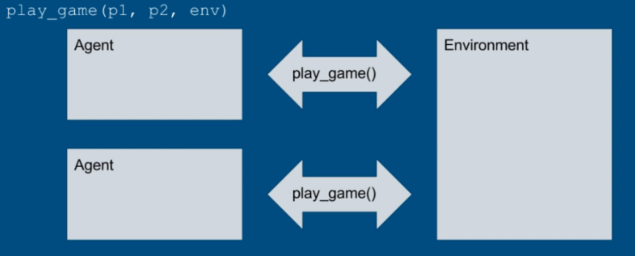

<span style='color:blue'> At a high level, we'll have two main objects: the agent and the enviroment.</span>

<span style='color:blue'>During any game there will be 2 instances of the agent object. And they will both interact with the same single instance of the envirment.</span>

<span style='color:blue'>In order to make these things intract we can create a function called play game which accepts the agent from player one, the agent from player 2, and the enviroment object.</span>

In [ ]:
def play_game(p1,p2,env,draw=False):
    # loops until the game is over
    current_player = None #(while loop,checks if the game is over)
    while not env.game_over():
        # alternate between players (switch whom the current player is) 
        # p1 always starts first
        if current_player == p1:
            current_player = p2
        else:
            current_player = p1
            
        #draw the board before the user who wants to see it makes a move
        # (Draw board function)
        if draw:
            if draw == 1 and current_player == p1:
                env.draw_board()
            if draw == 2 and current_player == p2:
                env.draw_board()
        # Current player makes a move (Agent take action function)
        # (We need to make the current player perform an action that update the enviroment)
        current_player.take_action(env)
        
        # Updates state histories
        state = env.get_state()
        p1.update_state_history(state)
        p2.update_state_history(state)
        
    if draw:
        env.draw_board()
        
    # do the value function update
    p1.update(env)
    p2.update(env)
    

#### What should go inside the play_game function?
- Inside the function it is basically a single loop.
- It loops until the game is over.
- At each iteration of the loop we need to do a few things.
- We need to make the current player perform an action that update the enviroment
- So we need to switch whom the current player is on order to alternante between players.
- Third we need to check if the current game is over (current_player= None, while not env.game_over(): )
- Here we have created a partial API for some instance methodS that our objects will need.
- The enviroment is will be the game over function that returns a boolean. True if the game is over. False if the game is not.

- This will have to check the board to see if the board is full and there is a winner or if its full but there is no winner then it is a draw.
- The agent will need a take action function. Which accepts as a parameter the enviroment. This will update the enviroment and hence the state.


- Another function we will need on the agent is the update function. The update function, updates the agent's internal estimate of the value function. This is where the update equation previously discussed is going to go $$V(s) \leftarrow V(s)+ \alpha (V(s^{'}) - V(s) ) $$. The update function will have to query the enviroment as well since, it will have to querry the most current reward from the current enviroment.


- Another function that is extremely useful however not strictly necessary is the draw board function. This displays what positions are currently occupied and by what pieces (X or O) .

## 2) Tic Tac Toe Code: Representing the states:

<span style='color:blue'> 
How are we going to represent states in our tic-tac-toe game?
    </span>
    
<span style='color:blue'> 
Earlier we discussed how this could be a O of one lookup, which in python is basically an array (matrix) / or a list of tuples.
    </span>
    
<span style='color:blue'> 
One way to accomplish this would be to use a dictionary, since the keys to a dictionary since the keys to a dictionary can be any immutable object. So we could repredent the game as a 2D tuple of size 3 by 3 and store the values inside as tuple elements.
    </span>
    
 <span style='color:blue'> 
However we can do this so that each state maps to a number, and by doing that we can store the value function as a numpy array.
  </span>

- Earlier, We discussed how there will be a [O(1) lookup](https://stackoverflow.com/questions/25541478/why-is-lookup-in-an-array-o1) (as in an array)
- Possible solution: convert the board to a tuple of tuples, use a dictionary key
- Better solution: Map each state into a number, use Numpy array

#### Mapping state to a number
 <span style='color:blue'> 
How do we code a state to a number? 
  </span>
  
  <span style='color:blue'> 
Notice that $3^{9}$ also encodes impossible states such as an X in all the 9 locations.
Some states are overheads and cannot be reached such as an x at each point on the board as you only need 3 X's to win. These overheads do not affect the algorithm at all so we will not worry about it. These states are never reachable anyway, since at each iteration of the loop we are going to check if the game is over and if it is we will quit the loop.
  </span>
  
  <span style='color:blue'> 
So these impossible values never show up in the state history meaning that they're values will never be used or updated.
  </span>
  
- $3^{9} = 19683$ states, not impossible as we have a small board (3 by 3) in Tic-Tac-Toe
- Overhead not a problem, these states are unreachable (e.g. 3 X's in a row and 3 o's in a row on the same board)

 

2:13

- Should remind you of binary numbers (2 possible symbols in each location VS. 3)
- Binary to decimal
$$ D = 2^{N-1} b_{N-1} + \dots + 2^{1} b_{1} + 2^{0} b_{0} $$
- For us:
$$D = 3^{N-1} b_{N-1} + \dots + 3^{1} b_{1} + 3^{0} b_{0}$$

 <span style='color:blue'> 
In code, it's going to look like this. Notice how we loop through each location on the board, which requires a nested four loop but that's only because of the structure of the board.
</span>

 <span style='color:blue'> 
We need to keep track of the power which starts at three to the power zero and gets multiplied by three on each new location so we keep track of that with the variable k.
</span> 

 <span style='color:blue'> 
We use the variable h to accumulate the final result. We use the letter h because h stands for hash and that's essentially what we're doing when hashing an object, and the output is an integer.
    </span> 

In [ ]:
# env is the instance of a class

def get_state_hash_and_winner(env, i=0, j=0):
    results = []
    
    for v in (0, env.x, env.o):
        env.board[i,j] = v# if the board is empty should already be 0
        if j == 2:
            # j goes back to 0, increase i, unless i=2, then we are done
            if i ==2:
                # the board is full, collect results and return
                state = env.get_state()
                ended = env.game_over( force_recalculate=True)
                winner = env.winner
                results.append((state,winner,ended))
            else:
                results += get_state_hash_and_winner(env, i+1, 0)
        else:
            # increment j, i stays the same
            results += get_state_hash_and_winner(env,i,j+1)
    return results

- If i ==2 and j == 2 then we are filling up the last location on the board. 
- This means we should  now check the game state, which means check whom the winner is and whether or not the game has ended.

## Summarizing Tic-tac-toe


Summary:
    - First, what is the most naive solution to the tic-tac-toe problem.
        - Answer is we would end up building an agent with a bunch of if statements.
    - Would not be able to increase intelligence by learning from experience.
    - Would not be generalizable to other enviroments.
        
<span style='color:blue'> 
It would not adapt to its enviroment or get better as it is played for more games. So even if it seemed intelligent at first it would not be able to increase its intelligence.
</span>

<span style='color:blue'> 
Moreover the algorithm would not be generalizable to new games. It would just work for tic tac toe. So, we have set out to find algorithms that are intelligent and that can potentially solve anything given the right rewards.
</span>
    - Next, we took a deeper look at **Components of a RL system**
    - Agent, Enviroment, state, action and reward
    - Episodes, terminal states
    - Choosing rewards carefully
 <span style='color:blue'> 
We discussed defined the terms: agents, enviroment, state, action and reward. We discussed how reward structures can lead to poor results. Hence, we need to choose them carefully. We looked at new terms like episode and terminal states. We needed to understand these concepts in order to implement Tic-tac-toe.
</span>

- Next, we looked at:
    - Credit Assignment problem
    - Delayed reward
    - Planning intgelligently to maximize the overall rewards
- Value function
- $V(s) \leftarrow V(s) + \alpha [V(s^{'}) - V(s)]$ 
- We then saw this in implementation

 <span style='color:blue'> 

</span>